<a href="https://colab.research.google.com/github/ajasja/PROPER/blob/main/PROPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROPER -- Single-chain permuted proteins for dimerization-based control of protein activity and cellular processes

Strategies for detecting and controlling protein interactions play a critical role in gaining an insight into molecular mechanisms of biological processes and for the control of cellular processes. Conditional protein reconstitution allows control of the selected protein function based on the proximity, defined by the genetically fused domain pairs, which may be regulated by chemical or biological signals. This typically requires two protein components in a stoichiometric ratio, which increases the complexity and genetic footprint with split segments often being unstable and prone to aggregation. To overcome this limitation, we developed an approach based on a permuted protein reconstitution by conditional dimerization (PROPER). According to this strategy, the N- and C-terminal domains of selected proteins are swapped and a loop replaced by a short linker that prevents the functionality of a monomeric protein, which reconstitutes only upon di- or oligomerization, controlled by a genetically fused domain that dimerizes by a chemical signal or senses a dimeric target.

This notebook enables the design of permuted "PROPER" proteins.

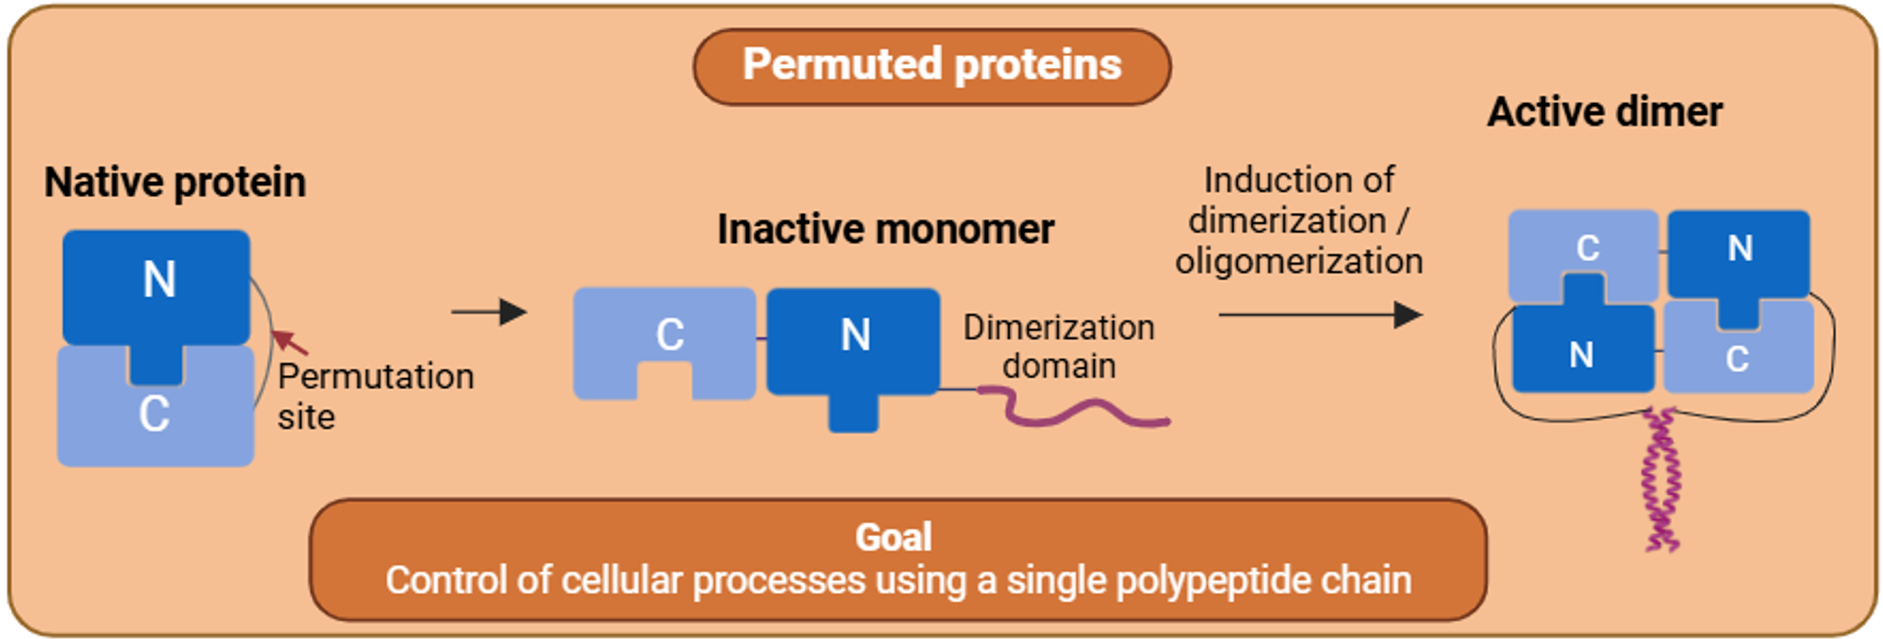

In [1]:
#@title Setup and import packages
#@markdown This step takes ~1 minute.
!pip install py3Dmol biopython mdtraj pdb-tools> /dev/null
import py3Dmol
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets.widgets import IntSlider, Layout, FloatSlider, Checkbox, ToggleButtons, HBox, VBox, Button, Text
from pathlib import Path

! pip install --upgrade git+https://github.com/ajasja/PROPER.git > /dev/null

import proper

  Running command git clone --filter=blob:none --quiet https://github.com/ajasja/PROPER.git /tmp/pip-req-build-3xgm984t


In [2]:
from logging import exception
#@title Upload pdb
#@markdown Please enter a PDB ID or leave empty to upload your own PDB structure.
#@markdown A "Choose Files" button that will appear below after running this cell.
#@markdown Structure will be re-numbered starting from 1.
#@markdown Currently only single chain proteins are supported

from google.colab import files
from pathlib import Path
import os

pdb = "1Q31" #@param {type:"string"}
#chain_ID = "A" #@param {type:"string"}


def get_pdb(pdb_code=None):
  if len(pdb_code) == 4:
    !pdb_fetch -biounit {pdb_code} > {pdb_code}.pdb
    print(f"Downloaded {pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif pdb_code.strip() == "":
    upload_dict = files.upload()
    pdb_string = list(upload_dict.keys())[0]
    return pdb_string
  else:
    raise Exception("invalid PDB code")

up_file_name = get_pdb(pdb_code=pdb)
up_file_stem = Path(up_file_name).stem
proper.clean_pdb(up_file_name)

with open(up_file_name, 'r') as file:
    model = file.read()


from Bio.PDB import PDBParser, PPBuilder, PDBIO

analyzer=proper.LoopAnalyzer(up_file_name, include_dssp='L')
print('Seq:'+analyzer.seq)

Downloaded 1Q31.pdb
Seq:LFKGPRDYNPISSTICHLTNESDGHTTSLYGIGFGPFIITNKHLFRRNNGTLLVQSLHGVFKVKNTTTLQQHLIDGRDMIIIRMPKDFPPFPQKLKFREPQREERICLVTTNFQTKSMSSMVSDTSCTFPSSDGIFWKHWIQTKDGQAGSPLVSTRDGFIVGIHSASNFTNTNNYFTSVPKNFMELLTNQEAQQWVSGWRLNADSVLWGGHKVFMSKPEMNELVYSQ


In [11]:
#@title Run the suggestions
#@markdown executing the cell will create an interactive GUI where the best permutation sites can will be suggested and visualised.
from pathlib import Path

out = widgets.Output(layout=widgets.Layout(border= '1px solid black',
    width='800px',   # fixed width
    height='480px',  # fixed height
    overflow='auto'  # enable scrollbars if content overflows})
))



p = py3Dmol.view(width=800, height=480)

p.addModels(model, "pdb")

p.setStyle({'cartoon': {'color':'spectrum'}})

p.zoomTo()
p.show()

# a flag that indicates whether the predictive model was applied
predictions_made = False

def on_position_change(change):
    p.addStyle({'sphere':{'hidden':True}});
    p.addStyle({'resi': position.value, 'atom': 'CA'}, {'sphere':{'color': 'green', 'scale':2, 'hidden':False}});
    if predictions_made:
        for best_pos in best_three_resi_index1:
            if position.value != best_pos: # Sadly does not want to show two spheres at the same time...
                p.addStyle({'resi': best_pos, 'atom': 'CA'}, {'sphere':{'color': 'green', 'opacity':0.5, 'scale':1.5, 'hidden':False}});
    p.update()

def on_find_pos_click(change):
    global predictions_made, analyzer
    permutation_sites = analyzer.suggest_sites('resi_burial_percent<50', one_site_per_loop=True)
    print(permutation_sites)

def find_features():
    features=analyzer.analyze_structure()

    return features



def on_save_features_click(change):
    base_name = Path(up_file_name).with_suffix('')
    feat_name = base_name.with_suffix('.features.xlsx')
    desc_name = base_name.with_suffix('.descriptions.xlsx')

    analyzer.residue_features_table.to_excel(feat_name)
    analyzer.resi_feature_descriptions.to_excel(desc_name)
    from google.colab import files
    files.download(feat_name)
    files.download(desc_name)

    print("Features saved!")


wide_layout = dict(description_width="initial")
position=IntSlider(min=1, max=len(analyzer.seq), value=1, step=1, continuous_update=True,
                  description='insert position',
                  tooltip='Position of CC insertion', style=wide_layout)
position.observe(on_position_change, names='value')
on_position_change(position)

find_pos=Button(description='Suggest best sites', tooltip='Suggest best permutation sites')
find_pos.on_click(on_find_pos_click)
find_pos.style.button_color = 'lightgreen'

save_features=Button(description='Save features', tooltip='Save the features used suggesting')
save_features.on_click(on_save_features_click)

active_site = widgets.Text(
    description='Functional site residues:',
    tooltip='List of functional (active or binding) site residues. Numbering is form 1 to N.',
    style=wide_layout
)

name_input = widgets.Text(
    value=up_file_stem,
    description='Name of structure:',
    style = wide_layout
)


link1 = widgets.Dropdown(
    options=['GSSGS', 'SPGGS', 'SGSSGS'],
    value='GSSGS',
    description='Linker 1:',
    tooltip='Select N-terminal linker for CC'
)

link2 = widgets.Dropdown(
    options=['GSGGS', 'GGSGGG'],
    value='GSGGS',
    description='Linker 2:',
    tooltip='Select C-terminal linker for CC'
)



include_L = widgets.Checkbox(
    value=True,
    description='Include loops'
)
include_H = widgets.Checkbox(
    value=False,
    description='Include helices'
)
include_E = widgets.Checkbox(
    value=False,
    description='Include strands'
)


include_label = widgets.Label("Secondary structure to consider for prediction:", style=wide_layout)

display(
    HBox([widgets.Label("Residues are counted from 1 to N.")]),
    HBox([active_site, name_input]),
    HBox([include_label, VBox([include_L, include_H, include_E])]),
    HBox([position, find_pos, save_features]),
    HBox([out])

)
